In [1]:
# Set display width, load packages, import symbols
ENV["COLUMNS"]=72
using Distributions
using Interpolations
using Knet: Knet, dir, accuracy, progress, sgd, load143, save, gc, Param, KnetArray, Data, minibatch, nll, relu, training, dropout,sigm # param, param0, xavier_uniform
using Knet
using Images
using Plots
using PyPlot
using PyPlot: savefig
using LinearAlgebra
using IterTools: ncycle, takenth
using MLDatasets
using Base.Iterators: flatten
import CUDA # functional
using ImageTransformations
using Statistics
using Memento
using NPZ
using Random
# using Interpolations
atype=(CUDA.functional() ? KnetArray{Float32} : Array{Float32})

┌ Warning: You are using Matplotlib 2.1.2, which is no longer
│ officialy supported by the Plots community. To ensure smooth Plots.jl
│ integration update your Matplotlib library to a version >= 3.4.0
│ 
│ If you have used Conda.jl to install PyPlot (default installation),
│ upgrade your matplotlib via Conda.jl and rebuild the PyPlot.
│ 
│ If you are not sure, here are the default instructions:
│ 
│ In Julia REPL:
│ ```
│ import Pkg;
│ Pkg.add("Conda")
│ import Conda
│ Conda.update()
│ Pkg.build("PyPlot")
│ ```
│ 
└ @ Plots /kuacc/users/bbozkurt15/.julia/packages/Plots/qbc7U/src/backends/pyplot.jl:29


KnetArray{Float32, N} where N

In [2]:
pwd()

"/scratch/users/bbozkurt15/MyJulia/GON_Project_Deployables/Evaluation_Notebook"

In [3]:
cd("..")

In [4]:
pwd()

"/scratch/users/bbozkurt15/MyJulia/GON_Project_Deployables"

In [5]:
const F = Float32
params = Knet.params

logger = Memento.config!("info"; fmt="[{date} | {level} | {name}]: {msg}");

include("PlotUtility.jl")
include("ImageUtility.jl")
include("TrainUtility.jl")
include("LayerUtility.jl")
include("LossUtility.jl")

using .PlotUtility
using .ImageUtility
using .TrainUtility
using .LayerUtility
using .LossUtility

In [6]:
use_saved_data = false
nc = nothing
dataset_name = "mnist"
if dataset_name == "mnist"
    nc = 1
    if use_saved_data
        xtrn = npzread("Data/MNIST_Train_Images.npy")
        xtrn = permutedims(xtrn, (3,4,2,1))
        xtst = npzread("Data/MNIST_Test_Images.npy")
        xtst = permutedims(xtst, (3,4,2,1))

    else

        xtrn,_ = MNIST.traindata()
        xtst,_ = MNIST.testdata()
        xtrn = Array{Float64, 3}(xtrn)
        xtst = Array{Float64, 3}(xtst)

        xtrn = resize_MNIST(xtrn, 32/28)
        xtst = resize_MNIST(xtst, 32/28)
        
    end
    
elseif dataset_name == "fashion"
    nc = 1
    if use_saved_data

        xtrn = npzread("Data/Fashion_MNIST_Train_Images.npy")
        xtrn = permutedims(xtrn, (3,4,2,1))
        xtst = npzread("Data/Fashion_MNIST_Test_Images.npy")
        xtst = permutedims(xtst, (3,4,2,1))
        
    else
        
        xtrn,_ = FashionMNIST.traindata()
        xtst,_ = FashionMNIST.testdata()
        xtrn = Array{Float64, 3}(xtrn)
        xtst = Array{Float64, 3}(xtst)

        xtrn = resize_MNIST(xtrn, 32/28)
        xtst = resize_MNIST(xtst, 32/28)

    end
    
elseif dataset_name == "cifar"
    nc = 3
    xtrn,_= CIFAR10.traindata()
    xtst,_ = CIFAR10.testdata()
    xtrn = Array{Float64, 4}(xtrn)
    xtst = Array{Float64, 4}(xtst)
#     println("No implemented yet")
end

batch_size = 64

dtrn = minibatch(xtrn, batch_size; xsize = (32, 32, nc,:), xtype = atype, shuffle = true)
dtst = minibatch(xtst, batch_size; xsize = (32, 32, nc,:), xtype = atype);

# GON MNIST - NGF : 16, NZ : 256

In [7]:
results_path = "./Results/GON_Autoencoder_ngf16_nz256_mnist1"
model_path = joinpath(results_path, "Saved_Models")

"./Results/GON_Autoencoder_ngf16_nz256_mnist1/Saved_Models"

In [8]:
readdir(results_path)

7-element Vector{String}:
 "Images"
 "Logger"
 "Saved_Models"
 "trn_loss_list.jld2"
 "trn_rec_loss_list.jld2"
 "tst_loss_list.jld2"
 "tst_rec_loss_list.jld2"

In [9]:
readdir(model_path)

10-element Vector{String}:
 "Model_Base1050.jld2"
 "Model_Base1100.jld2"
 "Model_Base1150.jld2"
 "Model_Base1200.jld2"
 "Model_Base1250.jld2"
 "Model_Base1300.jld2"
 "Model_Base1350.jld2"
 "Model_Base1400.jld2"
 "Model_Base1450.jld2"
 "Model_Base1500.jld2"

## Read Train and Test Losses

In [10]:
trn_loss_list = Knet.load(joinpath(results_path,"trn_loss_list.jld2"), )["trn_loss_list"]
tst_loss_list = Knet.load(joinpath(results_path,"tst_loss_list.jld2"), )["tst_loss_list"]
trn_rec_loss_list = Knet.load(joinpath(results_path,"trn_rec_loss_list.jld2"), )["trn_rec_loss_list"]
tst_rec_loss_list = Knet.load(joinpath(results_path,"tst_rec_loss_list.jld2"), )["tst_rec_loss_list"];

In [11]:
trn_loss_list[end], tst_loss_list[end], trn_rec_loss_list[end], tst_rec_loss_list[end]

(0.00011484675633255392, 0.00013897399185225368, 0.11755438894033432, 0.14230936765670776)

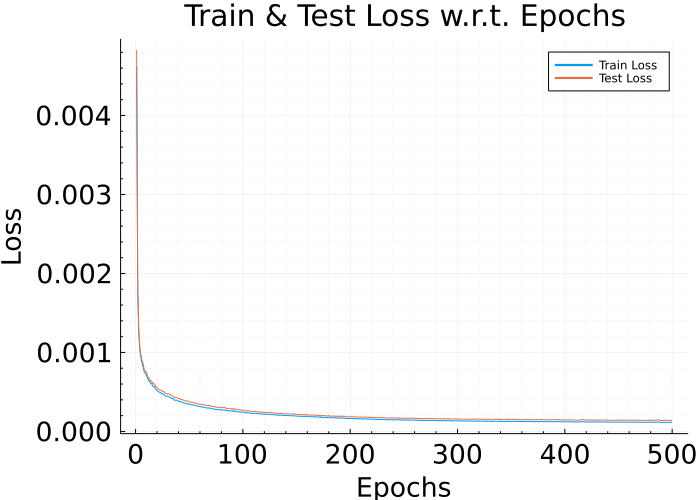

In [12]:
plot_loss_convergence(trn_loss_list[2:end], tst_loss_list[2:end], title = "Train & Test Loss w.r.t. Epochs")

## Read Model Weight for Visualization

In [13]:
model_500 = value.(Knet.load(joinpath(model_path,"Model_Base1500.jld2"), )["model"][:decoder]);

In [14]:
moments1 = bnmoments()
moments2 = bnmoments()
moments3 = bnmoments()

function decode(theta, z; batch_size = 64, training = true)
    
    z = deconv4(theta[1], z, mode = 1) .+ theta[2]
    z = mybatchnorm(z, moments1, theta[3]; training = training)
    z = Knet.elu.(z)
    
    z = deconv4(theta[4], z, mode = 1, stride = 2, padding = 1) .+ theta[5]
    z = mybatchnorm(z, moments2, theta[6]; training = training)
    z = Knet.elu.(z)
    
    z = deconv4(theta[7], z, mode = 1, stride = 2, padding = 1) .+ theta[8]
    z = mybatchnorm(z, moments3, theta[9]; training = training)
    z = Knet.elu.(z)
    
    z = deconv4(theta[10], z, mode = 1, stride = 2, padding = 1) .+ theta[11]
    x_hat = Knet.sigm.(z)
    return x_hat
    
end

decode (generic function with 1 method)

In [15]:
x = first(dtst)
nz = 256
ngf = 16
# (Reconstruction Error := Mean Squared Error)
inner_loss(x, z) = mean(sum((decode(model_500, z; batch_size = size(x,4)) - x).^2, dims = 3))

origin = Param(atype(zeros(1, 1, nz, batch_size)))
derivative_origin = @diff inner_loss(x,origin)
dz = grad(derivative_origin, origin)
z = -dz
x_hat = decode(model_500, z; batch_size = batch_size, training = true);

nothing

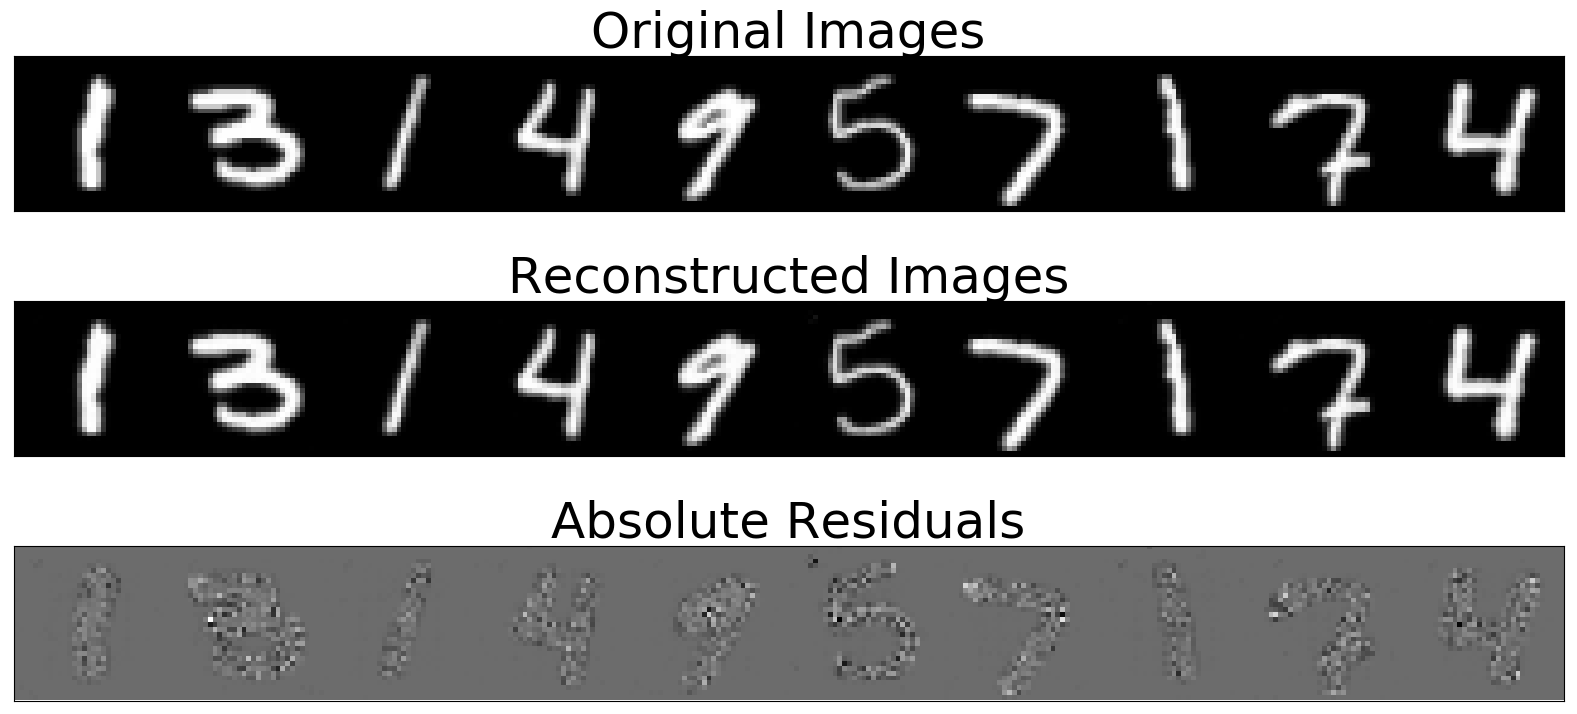

In [16]:
x_hat_ = Array{Float32}(reshape(x_hat, 32,32,1,64))
x_ = Array{Float32}(reshape(x, 32,32,1,64))
display(plot_reconstructed_images_pyplot(x_, x_hat_; transpose_image = false))
figname = "mnist_gon_test_reconstructions_nz256"
plt.savefig(joinpath("Evaluation_Notebook", figname))

# GON CIFAR - NGF : 16, NZ : 512

In [17]:
use_saved_data = false
nc = nothing
dataset_name = "cifar"
if dataset_name == "mnist"
    nc = 1
    if use_saved_data
        xtrn = npzread("Data/MNIST_Train_Images.npy")
        xtrn = permutedims(xtrn, (3,4,2,1))
        xtst = npzread("Data/MNIST_Test_Images.npy")
        xtst = permutedims(xtst, (3,4,2,1))

    else

        xtrn,_ = MNIST.traindata()
        xtst,_ = MNIST.testdata()
        xtrn = Array{Float64, 3}(xtrn)
        xtst = Array{Float64, 3}(xtst)

        xtrn = resize_MNIST(xtrn, 32/28)
        xtst = resize_MNIST(xtst, 32/28)
        
    end
    
elseif dataset_name == "fashion"
    nc = 1
    if use_saved_data

        xtrn = npzread("Data/Fashion_MNIST_Train_Images.npy")
        xtrn = permutedims(xtrn, (3,4,2,1))
        xtst = npzread("Data/Fashion_MNIST_Test_Images.npy")
        xtst = permutedims(xtst, (3,4,2,1))
        
    else
        
        xtrn,_ = FashionMNIST.traindata()
        xtst,_ = FashionMNIST.testdata()
        xtrn = Array{Float64, 3}(xtrn)
        xtst = Array{Float64, 3}(xtst)

        xtrn = resize_MNIST(xtrn, 32/28)
        xtst = resize_MNIST(xtst, 32/28)

    end
    
elseif dataset_name == "cifar"
    nc = 3
    xtrn,_= CIFAR10.traindata()
    xtst,_ = CIFAR10.testdata()
    xtrn = Array{Float64, 4}(xtrn)
    xtst = Array{Float64, 4}(xtst)
#     println("No implemented yet")
end

batch_size = 64

dtrn = minibatch(xtrn, batch_size; xsize = (32, 32, nc,:), xtype = atype, shuffle = true)
dtst = minibatch(xtst, batch_size; xsize = (32, 32, nc,:), xtype = atype);

In [18]:
results_path = "./Results/GON_Autoencoder_ngf16_nz512_cifar1"
model_path = joinpath(results_path, "Saved_Models")

"./Results/GON_Autoencoder_ngf16_nz512_cifar1/Saved_Models"

In [19]:
readdir(results_path)

7-element Vector{String}:
 "Images"
 "Logger"
 "Saved_Models"
 "trn_loss_list.jld2"
 "trn_rec_loss_list.jld2"
 "tst_loss_list.jld2"
 "tst_rec_loss_list.jld2"

In [20]:
readdir(model_path)

10-element Vector{String}:
 "Model_Base1050.jld2"
 "Model_Base1100.jld2"
 "Model_Base1150.jld2"
 "Model_Base1200.jld2"
 "Model_Base1250.jld2"
 "Model_Base1300.jld2"
 "Model_Base1350.jld2"
 "Model_Base1400.jld2"
 "Model_Base1450.jld2"
 "Model_Base1500.jld2"

In [21]:
trn_loss_list = Knet.load(joinpath(results_path,"trn_loss_list.jld2"), )["trn_loss_list"]
tst_loss_list = Knet.load(joinpath(results_path,"tst_loss_list.jld2"), )["tst_loss_list"]
trn_rec_loss_list = Knet.load(joinpath(results_path,"trn_rec_loss_list.jld2"), )["trn_rec_loss_list"]
tst_rec_loss_list = Knet.load(joinpath(results_path,"tst_rec_loss_list.jld2"), )["tst_rec_loss_list"];

In [22]:
trn_loss_list[end], tst_loss_list[end], trn_rec_loss_list[end], tst_rec_loss_list[end]

(0.0032831071875989437, 0.0033330274745821953, 3.351231575012207, 3.413020133972168)

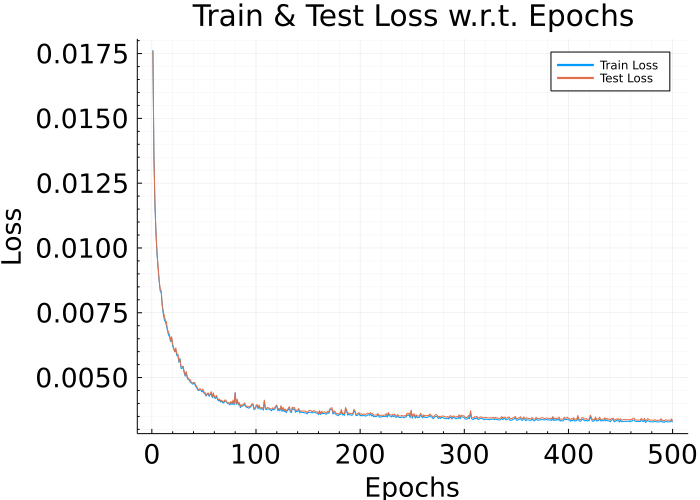

In [23]:
plot_loss_convergence(trn_loss_list[2:end], tst_loss_list[2:end], title = "Train & Test Loss w.r.t. Epochs")

In [24]:
model_500 = value.(Knet.load(joinpath(model_path,"Model_Base1500.jld2"), )["model"][:decoder]);

In [25]:
x = first(dtst)
nz = 512
ngf = 16
# (Reconstruction Error := Mean Squared Error)
inner_loss(x, z) = mean(sum((decode(model_500, z; batch_size = size(x,4)) - x).^2, dims = 3))

origin = Param(atype(zeros(1, 1, nz, batch_size)))
derivative_origin = @diff inner_loss(x,origin)
dz = grad(derivative_origin, origin)
z = -dz
x_hat = decode(model_500, z; batch_size = batch_size, training = true);

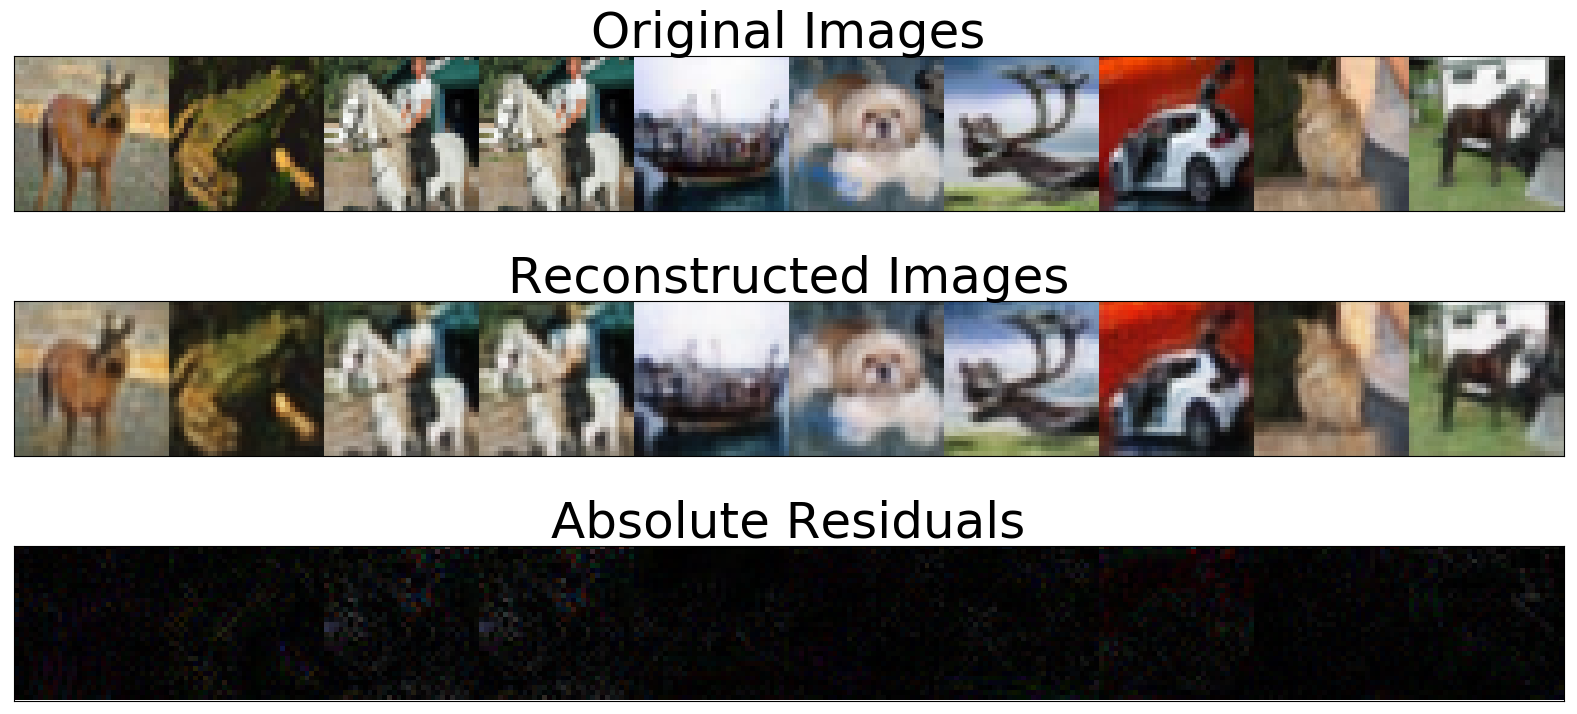

In [26]:
# x_hat_ = Array{Float32}(reshape(x_hat, 32,32,1,64))
# x_ = Array{Float32}(reshape(x, 32,32,1,64))
(plot_reconstructed_images_pyplot(x, x_hat))
figname = "cifar_gon_test_reconstructions_nz512"
plt.savefig(joinpath("Evaluation_Notebook", figname))

# GON CIFAR - NGF : 16, NZ : 256

In [27]:
results_path = "./Results/GON_Autoencoder_ngf16_nz256_cifar1"
model_path = joinpath(results_path, "Saved_Models")

"./Results/GON_Autoencoder_ngf16_nz256_cifar1/Saved_Models"

In [28]:
readdir(results_path)

7-element Vector{String}:
 "Images"
 "Logger"
 "Saved_Models"
 "trn_loss_list.jld2"
 "trn_rec_loss_list.jld2"
 "tst_loss_list.jld2"
 "tst_rec_loss_list.jld2"

In [29]:
readdir(model_path)

10-element Vector{String}:
 "Model_Base1050.jld2"
 "Model_Base1100.jld2"
 "Model_Base1150.jld2"
 "Model_Base1200.jld2"
 "Model_Base1250.jld2"
 "Model_Base1300.jld2"
 "Model_Base1350.jld2"
 "Model_Base1400.jld2"
 "Model_Base1450.jld2"
 "Model_Base1500.jld2"

In [30]:
trn_loss_list = Knet.load(joinpath(results_path,"trn_loss_list.jld2"), )["trn_loss_list"]
tst_loss_list = Knet.load(joinpath(results_path,"tst_loss_list.jld2"), )["tst_loss_list"]
trn_rec_loss_list = Knet.load(joinpath(results_path,"trn_rec_loss_list.jld2"), )["trn_rec_loss_list"]
tst_rec_loss_list = Knet.load(joinpath(results_path,"tst_rec_loss_list.jld2"), )["tst_rec_loss_list"];

In [31]:
trn_loss_list[end], tst_loss_list[end], trn_rec_loss_list[end], tst_rec_loss_list[end]

(0.007424558978527784, 0.007534379605203867, 7.604866027832031, 7.715205192565918)

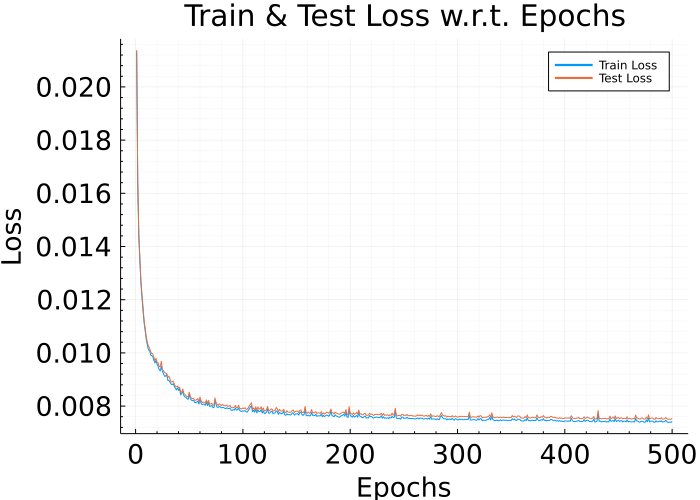

In [32]:
plot_loss_convergence(trn_loss_list[2:end], tst_loss_list[2:end], title = "Train & Test Loss w.r.t. Epochs")

In [33]:
model_500 = value.(Knet.load(joinpath(model_path,"Model_Base1500.jld2"), )["model"][:decoder]);

In [34]:
x = first(dtst)
nz = 256
ngf = 16
# (Reconstruction Error := Mean Squared Error)
inner_loss(x, z) = mean(sum((decode(model_500, z; batch_size = size(x,4)) - x).^2, dims = 3))

origin = Param(atype(zeros(1, 1, nz, batch_size)))
derivative_origin = @diff inner_loss(x,origin)
dz = grad(derivative_origin, origin)
z = -dz
x_hat = decode(model_500, z; batch_size = batch_size, training = true);

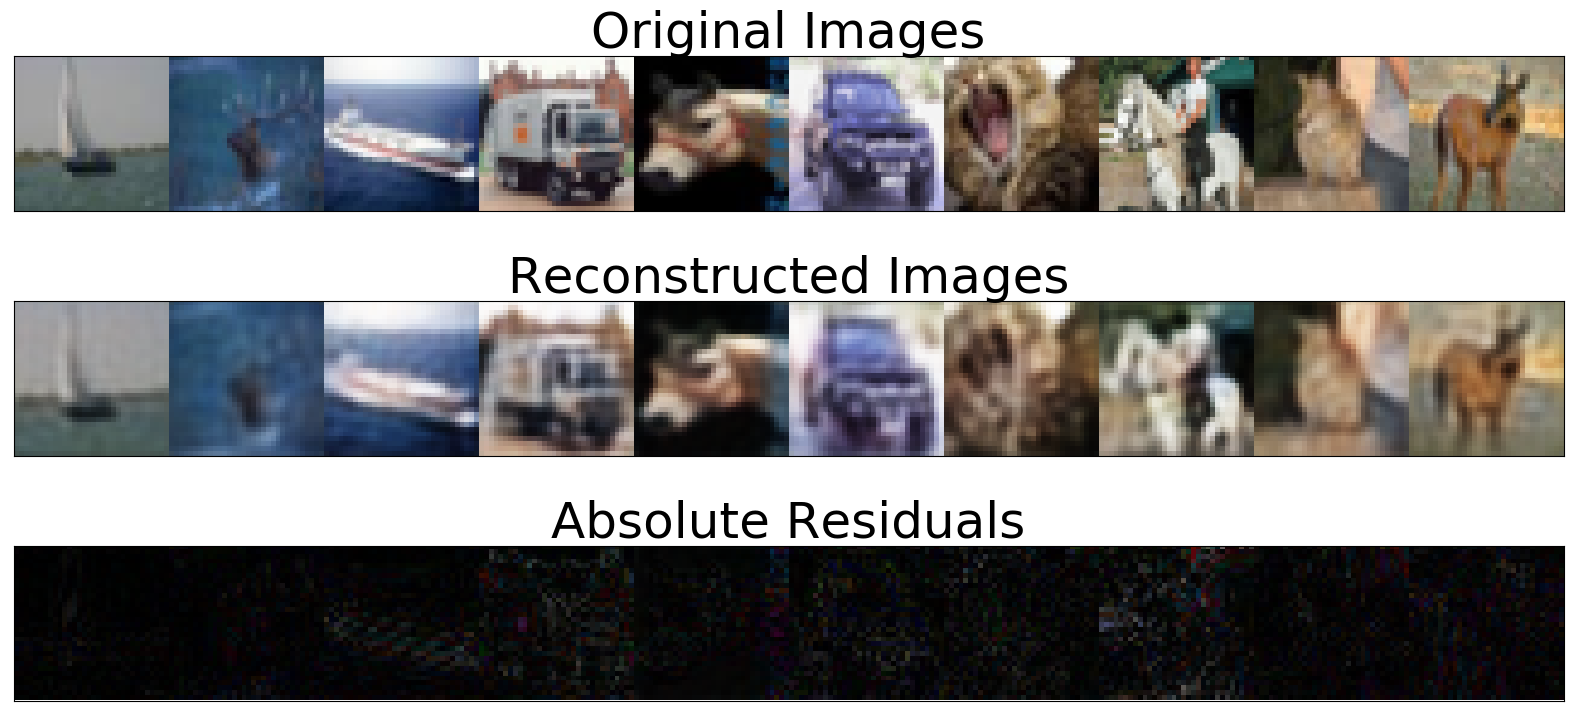

In [35]:
# x_hat_ = Array{Float32}(reshape(x_hat, 32,32,1,64))
# x_ = Array{Float32}(reshape(x, 32,32,1,64))
(plot_reconstructed_images_pyplot(x, x_hat))
figname = "cifar_gon_test_reconstructions_nz256"
plt.savefig(joinpath("Evaluation_Notebook", figname))

# GON Fashion-MNIST - NGF : 16, NZ : 256

In [36]:
use_saved_data = false
nc = nothing
dataset_name = "fashion"
if dataset_name == "mnist"
    nc = 1
    if use_saved_data
        xtrn = npzread("Data/MNIST_Train_Images.npy")
        xtrn = permutedims(xtrn, (3,4,2,1))
        xtst = npzread("Data/MNIST_Test_Images.npy")
        xtst = permutedims(xtst, (3,4,2,1))

    else

        xtrn,_ = MNIST.traindata()
        xtst,_ = MNIST.testdata()
        xtrn = Array{Float64, 3}(xtrn)
        xtst = Array{Float64, 3}(xtst)

        xtrn = resize_MNIST(xtrn, 32/28)
        xtst = resize_MNIST(xtst, 32/28)
        
    end
    
elseif dataset_name == "fashion"
    nc = 1
    if use_saved_data

        xtrn = npzread("Data/Fashion_MNIST_Train_Images.npy")
        xtrn = permutedims(xtrn, (3,4,2,1))
        xtst = npzread("Data/Fashion_MNIST_Test_Images.npy")
        xtst = permutedims(xtst, (3,4,2,1))
        
    else
        
        xtrn,_ = FashionMNIST.traindata()
        xtst,_ = FashionMNIST.testdata()
        xtrn = Array{Float64, 3}(xtrn)
        xtst = Array{Float64, 3}(xtst)

        xtrn = resize_MNIST(xtrn, 32/28)
        xtst = resize_MNIST(xtst, 32/28)

    end
    
elseif dataset_name == "cifar"
    nc = 3
    xtrn,_= CIFAR10.traindata()
    xtst,_ = CIFAR10.testdata()
    xtrn = Array{Float64, 4}(xtrn)
    xtst = Array{Float64, 4}(xtst)
#     println("No implemented yet")
end

batch_size = 64

dtrn = minibatch(xtrn, batch_size; xsize = (32, 32, nc,:), xtype = atype, shuffle = true)
dtst = minibatch(xtst, batch_size; xsize = (32, 32, nc,:), xtype = atype);

In [37]:
results_path = "./Results/GON_Autoencoder_ngf16_nz256_fashion1"
model_path = joinpath(results_path, "Saved_Models")

"./Results/GON_Autoencoder_ngf16_nz256_fashion1/Saved_Models"

In [38]:
readdir(results_path)

7-element Vector{String}:
 "Images"
 "Logger"
 "Saved_Models"
 "trn_loss_list.jld2"
 "trn_rec_loss_list.jld2"
 "tst_loss_list.jld2"
 "tst_rec_loss_list.jld2"

In [39]:
readdir(model_path)

10-element Vector{String}:
 "Model_Base1050.jld2"
 "Model_Base1100.jld2"
 "Model_Base1150.jld2"
 "Model_Base1200.jld2"
 "Model_Base1250.jld2"
 "Model_Base1300.jld2"
 "Model_Base1350.jld2"
 "Model_Base1400.jld2"
 "Model_Base1450.jld2"
 "Model_Base1500.jld2"

In [40]:
trn_loss_list = Knet.load(joinpath(results_path,"trn_loss_list.jld2"), )["trn_loss_list"]
tst_loss_list = Knet.load(joinpath(results_path,"tst_loss_list.jld2"), )["tst_loss_list"]
trn_rec_loss_list = Knet.load(joinpath(results_path,"trn_rec_loss_list.jld2"), )["trn_rec_loss_list"]
tst_rec_loss_list = Knet.load(joinpath(results_path,"tst_rec_loss_list.jld2"), )["tst_rec_loss_list"];

In [41]:
trn_loss_list[end], tst_loss_list[end], trn_rec_loss_list[end], tst_rec_loss_list[end]

(0.000589993316680193, 0.0006276923231780529, 0.6040522456169128, 0.6427569389343262)

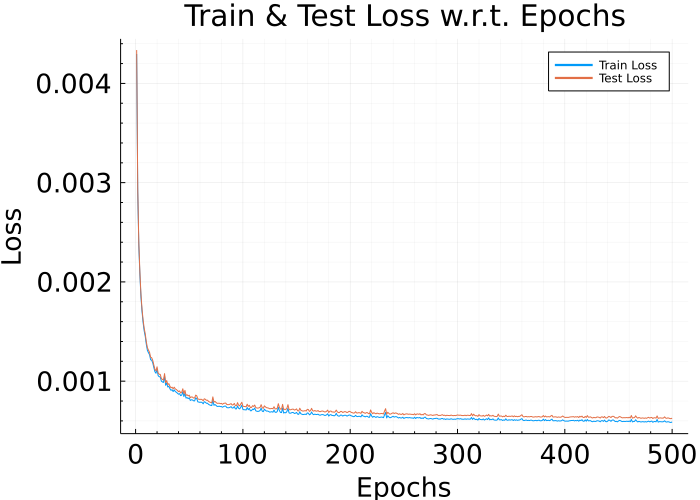

In [42]:
plot_loss_convergence(trn_loss_list[2:end], tst_loss_list[2:end], title = "Train & Test Loss w.r.t. Epochs")

In [43]:
model_500 = value.(Knet.load(joinpath(model_path,"Model_Base1500.jld2"), )["model"][:decoder]);

In [44]:
x = first(dtst)
nz = 256
ngf = 16
# (Reconstruction Error := Mean Squared Error)
inner_loss(x, z) = mean(sum((decode(model_500, z; batch_size = size(x,4)) - x).^2, dims = 3))

origin = Param(atype(zeros(1, 1, nz, batch_size)))
derivative_origin = @diff inner_loss(x,origin)
dz = grad(derivative_origin, origin)
z = -dz
x_hat = decode(model_500, z; batch_size = batch_size, training = true);

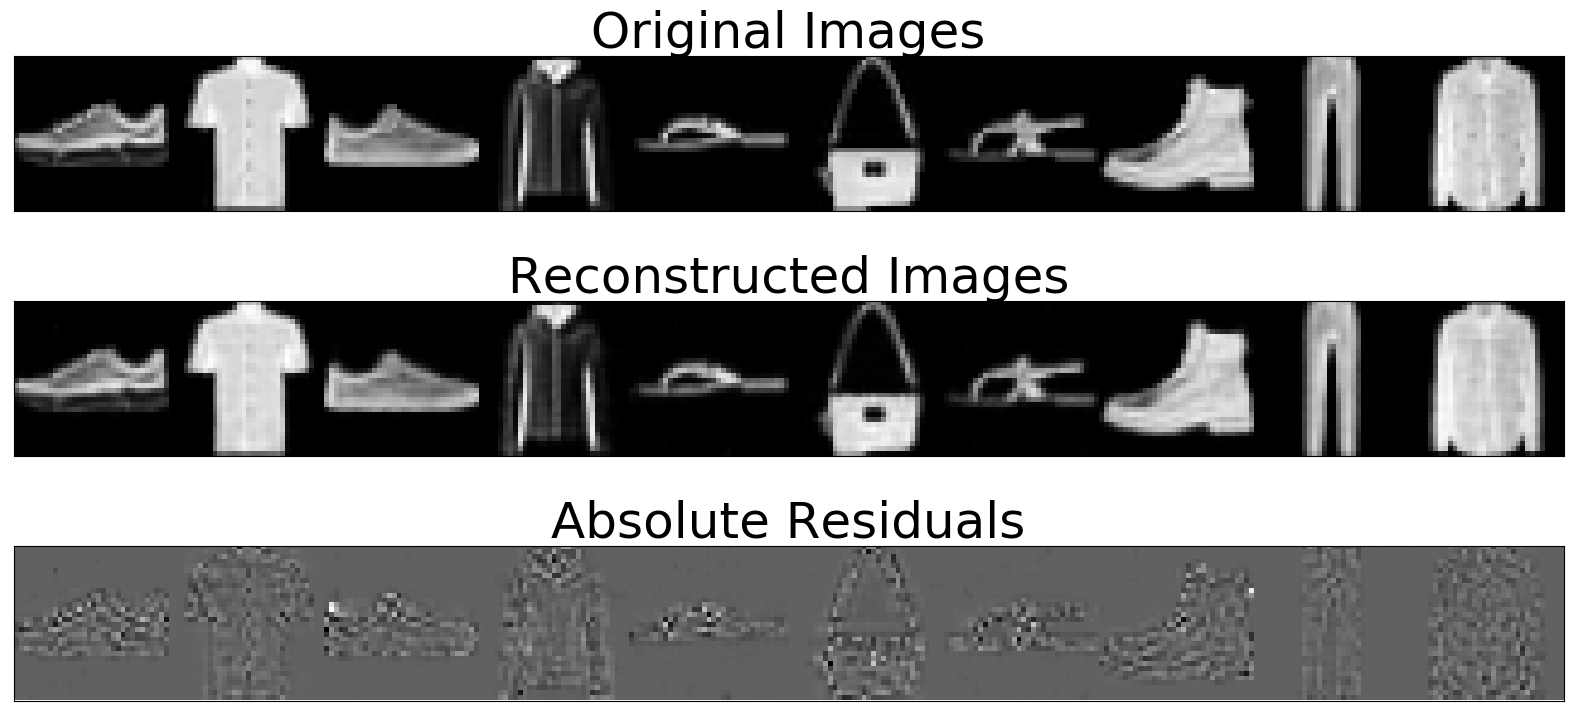

In [45]:
x_hat_ = Array{Float32}(reshape(x_hat, 32,32,1,64))
x_ = Array{Float32}(reshape(x, 32,32,1,64))
plot_reconstructed_images_pyplot(x_, x_hat_, transpose_image = false)
figname = "fashion_gon_test_reconstructions_nz256"
plt.savefig(joinpath("Evaluation_Notebook", figname))

# GON COIL-20 - NGF : 16, NZ : 256

In [46]:
use_saved_data = false
nc = nothing
dataset_name = "coil"
if dataset_name == "mnist"
    nc = 1
    if use_saved_data
        xtrn = npzread("Data/MNIST_Train_Images.npy")
        xtrn = permutedims(xtrn, (3,4,2,1))
        xtst = npzread("Data/MNIST_Test_Images.npy")
        xtst = permutedims(xtst, (3,4,2,1))

    else

        xtrn,_ = MNIST.traindata()
        xtst,_ = MNIST.testdata()
        xtrn = Array{Float64, 3}(xtrn)
        xtst = Array{Float64, 3}(xtst)

        xtrn = resize_MNIST(xtrn, 32/28)
        xtst = resize_MNIST(xtst, 32/28)
        
    end
    
elseif dataset_name == "fashion"
    nc = 1
    if use_saved_data

        xtrn = npzread("Data/Fashion_MNIST_Train_Images.npy")
        xtrn = permutedims(xtrn, (3,4,2,1))
        xtst = npzread("Data/Fashion_MNIST_Test_Images.npy")
        xtst = permutedims(xtst, (3,4,2,1))
        
    else
        
        xtrn,_ = FashionMNIST.traindata()
        xtst,_ = FashionMNIST.testdata()
        xtrn = Array{Float64, 3}(xtrn)
        xtst = Array{Float64, 3}(xtst)

        xtrn = resize_MNIST(xtrn, 32/28)
        xtst = resize_MNIST(xtst, 32/28)

    end
    
elseif dataset_name == "cifar"
    nc = 3
    xtrn,_= CIFAR10.traindata()
    xtst,_ = CIFAR10.testdata()
    xtrn = Array{Float64, 4}(xtrn)
    xtst = Array{Float64, 4}(xtst)

elseif dataset_name == "coil"
    coil_path = "Data/coil20"
    coil = load_coil_dataset(coil_path);
    nc = 1
    dataset_size = size(coil,3)
    trn_perc = 0.8
    trn_size = Int(dataset_size * trn_perc)
    random_permutation = randperm(dataset_size)
    trn_idx = random_permutation[1:trn_size]
    tst_idx = random_permutation[trn_size + 1:end]
    xtrn = coil[:,:,trn_idx]
    xtrn = resize_gray_image_tensor(xtrn, 1/4)
    xtst = coil[:,:,tst_idx];
    xtst = resize_gray_image_tensor(xtst, 1/4)

end

batch_size = 64

dtrn = minibatch(xtrn, batch_size; xsize = (32, 32, nc,:), xtype = atype, shuffle = true)
dtst = minibatch(xtst, batch_size; xsize = (32, 32, nc,:), xtype = atype);


In [47]:
results_path = "./Results/GON_Autoencoder_ngf16_nz256_coil1"
model_path = joinpath(results_path, "Saved_Models")

"./Results/GON_Autoencoder_ngf16_nz256_coil1/Saved_Models"

In [48]:
readdir(results_path)

9-element Vector{String}:
 "Images"
 "Logger"
 "Saved_Models"
 "Train_and_test_loss.png"
 "Train_and_test_reconstruction_loss.png"
 "trn_loss_list.jld2"
 "trn_rec_loss_list.jld2"
 "tst_loss_list.jld2"
 "tst_rec_loss_list.jld2"

In [49]:
trn_loss_list = Knet.load(joinpath(results_path,"trn_loss_list.jld2"), )["trn_loss_list"]
tst_loss_list = Knet.load(joinpath(results_path,"tst_loss_list.jld2"), )["tst_loss_list"]
trn_rec_loss_list = Knet.load(joinpath(results_path,"trn_rec_loss_list.jld2"), )["trn_rec_loss_list"]
tst_rec_loss_list = Knet.load(joinpath(results_path,"tst_rec_loss_list.jld2"), )["tst_rec_loss_list"];

In [50]:
trn_loss_list[end], tst_loss_list[end], trn_rec_loss_list[end], tst_rec_loss_list[end]

(0.0013448281679302454, 0.002536522224545479, 1.3667114973068237, 2.5973987579345703)

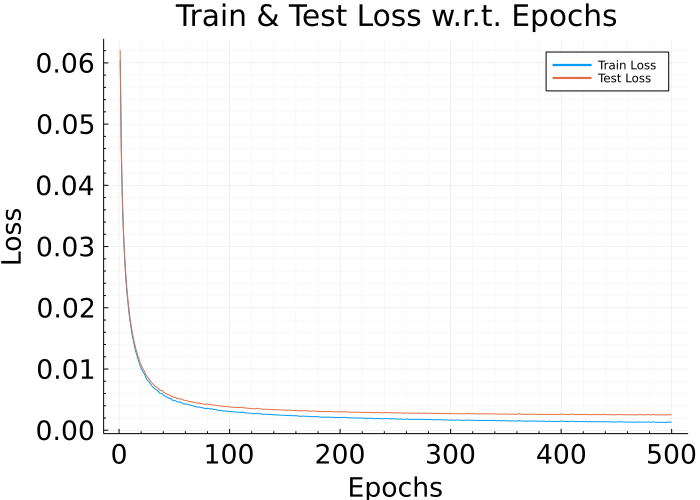

In [51]:
plot_loss_convergence(trn_loss_list[2:end], tst_loss_list[2:end], title = "Train & Test Loss w.r.t. Epochs")

In [52]:
model_500 = value.(Knet.load(joinpath(model_path,"Model_Base1500.jld2"), )["model"][:decoder]);

In [53]:
x = first(dtst)
nz = 256
ngf = 16
# (Reconstruction Error := Mean Squared Error)
inner_loss(x, z) = mean(sum((decode(model_500, z; batch_size = size(x,4)) - x).^2, dims = 3))

origin = Param(atype(zeros(1, 1, nz, batch_size)))
derivative_origin = @diff inner_loss(x,origin)
dz = grad(derivative_origin, origin)
z = -dz
x_hat = decode(model_500, z; batch_size = batch_size, training = true);

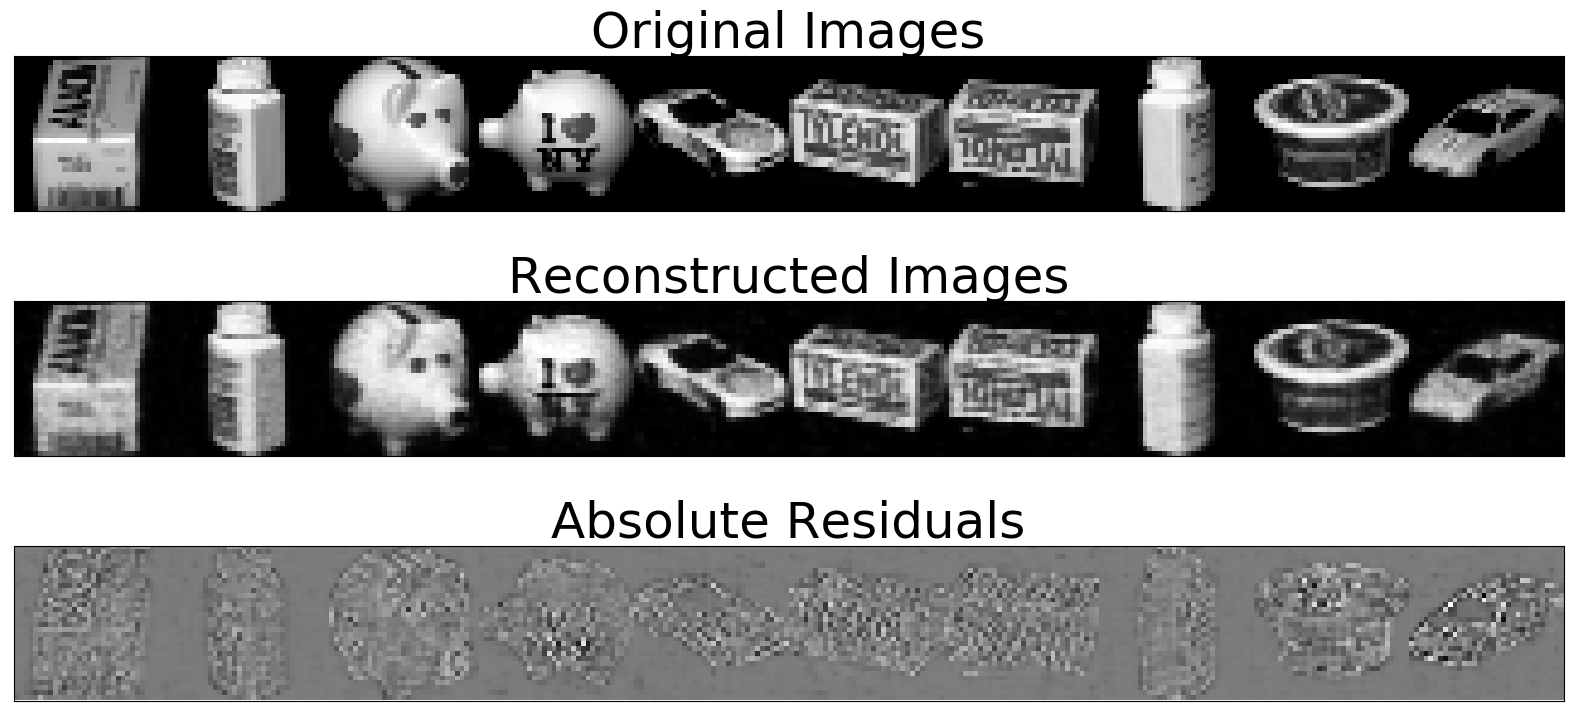

In [54]:
x_hat_ = Array{Float32}(reshape(x_hat, 32,32,1,64))
x_ = Array{Float32}(reshape(x, 32,32,1,64))
plot_reconstructed_images_pyplot(x_, x_hat_, transpose_image = false)
figname = "coil_gon_test_reconstructions_nz256"
plt.savefig(joinpath("Evaluation_Notebook", figname))

# GON 1 Step Detach MNIST - NGF : 16, NZ : 256

In [55]:
use_saved_data = false
nc = nothing
dataset_name = "mnist"
if dataset_name == "mnist"
    nc = 1
    if use_saved_data
        xtrn = npzread("Data/MNIST_Train_Images.npy")
        xtrn = permutedims(xtrn, (3,4,2,1))
        xtst = npzread("Data/MNIST_Test_Images.npy")
        xtst = permutedims(xtst, (3,4,2,1))

    else

        xtrn,_ = MNIST.traindata()
        xtst,_ = MNIST.testdata()
        xtrn = Array{Float64, 3}(xtrn)
        xtst = Array{Float64, 3}(xtst)

        xtrn = resize_MNIST(xtrn, 32/28)
        xtst = resize_MNIST(xtst, 32/28)
        
    end
    
elseif dataset_name == "fashion"
    nc = 1
    if use_saved_data

        xtrn = npzread("Data/Fashion_MNIST_Train_Images.npy")
        xtrn = permutedims(xtrn, (3,4,2,1))
        xtst = npzread("Data/Fashion_MNIST_Test_Images.npy")
        xtst = permutedims(xtst, (3,4,2,1))
        
    else
        
        xtrn,_ = FashionMNIST.traindata()
        xtst,_ = FashionMNIST.testdata()
        xtrn = Array{Float64, 3}(xtrn)
        xtst = Array{Float64, 3}(xtst)

        xtrn = resize_MNIST(xtrn, 32/28)
        xtst = resize_MNIST(xtst, 32/28)

    end
    
elseif dataset_name == "cifar"
    nc = 3
    xtrn,_= CIFAR10.traindata()
    xtst,_ = CIFAR10.testdata()
    xtrn = Array{Float64, 4}(xtrn)
    xtst = Array{Float64, 4}(xtst)
#     println("No implemented yet")
end

batch_size = 64

dtrn = minibatch(xtrn, batch_size; xsize = (32, 32, nc,:), xtype = atype, shuffle = true)
dtst = minibatch(xtst, batch_size; xsize = (32, 32, nc,:), xtype = atype);

In [56]:
results_path = "./Results/GON_1StepDetach_ngf16_nz256_mnist1"
model_path = joinpath(results_path, "Saved_Models")

"./Results/GON_1StepDetach_ngf16_nz256_mnist1/Saved_Models"

In [57]:
readdir(results_path)

7-element Vector{String}:
 "Images"
 "Logger"
 "Saved_Models"
 "trn_loss_list.jld2"
 "trn_rec_loss_list.jld2"
 "tst_loss_list.jld2"
 "tst_rec_loss_list.jld2"

In [58]:
trn_loss_list = Knet.load(joinpath(results_path,"trn_loss_list.jld2"), )["trn_loss_list"]
tst_loss_list = Knet.load(joinpath(results_path,"tst_loss_list.jld2"), )["tst_loss_list"]
trn_rec_loss_list = Knet.load(joinpath(results_path,"trn_rec_loss_list.jld2"), )["trn_rec_loss_list"]
tst_rec_loss_list = Knet.load(joinpath(results_path,"tst_rec_loss_list.jld2"), )["tst_rec_loss_list"];

In [59]:
trn_loss_list[end], tst_loss_list[end], trn_rec_loss_list[end], tst_rec_loss_list[end]

(0.0020529422909021378, 0.0024059570860117674, 2.102212905883789, 2.463700294494629)

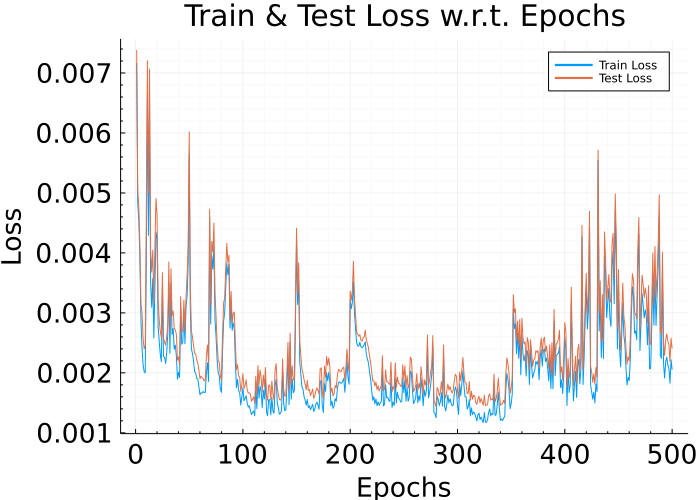

In [60]:
plot_loss_convergence(trn_loss_list[2:end], tst_loss_list[2:end], title = "Train & Test Loss w.r.t. Epochs")

In [61]:
model_500 = value.(Knet.load(joinpath(model_path,"Model_Base1500.jld2"), )["model"][:decoder]);

In [62]:
x = first(dtst)
nz = 256
ngf = 16
# (Reconstruction Error := Mean Squared Error)
inner_loss(x, z) = mean(sum((decode(model_500, z; batch_size = size(x,4)) - x).^2, dims = 3))

origin = Param(atype(zeros(1, 1, nz, batch_size)))
derivative_origin = @diff inner_loss(x,origin)
dz = grad(derivative_origin, origin)
z = -dz
x_hat = decode(model_500, z; batch_size = batch_size, training = true);

nothing

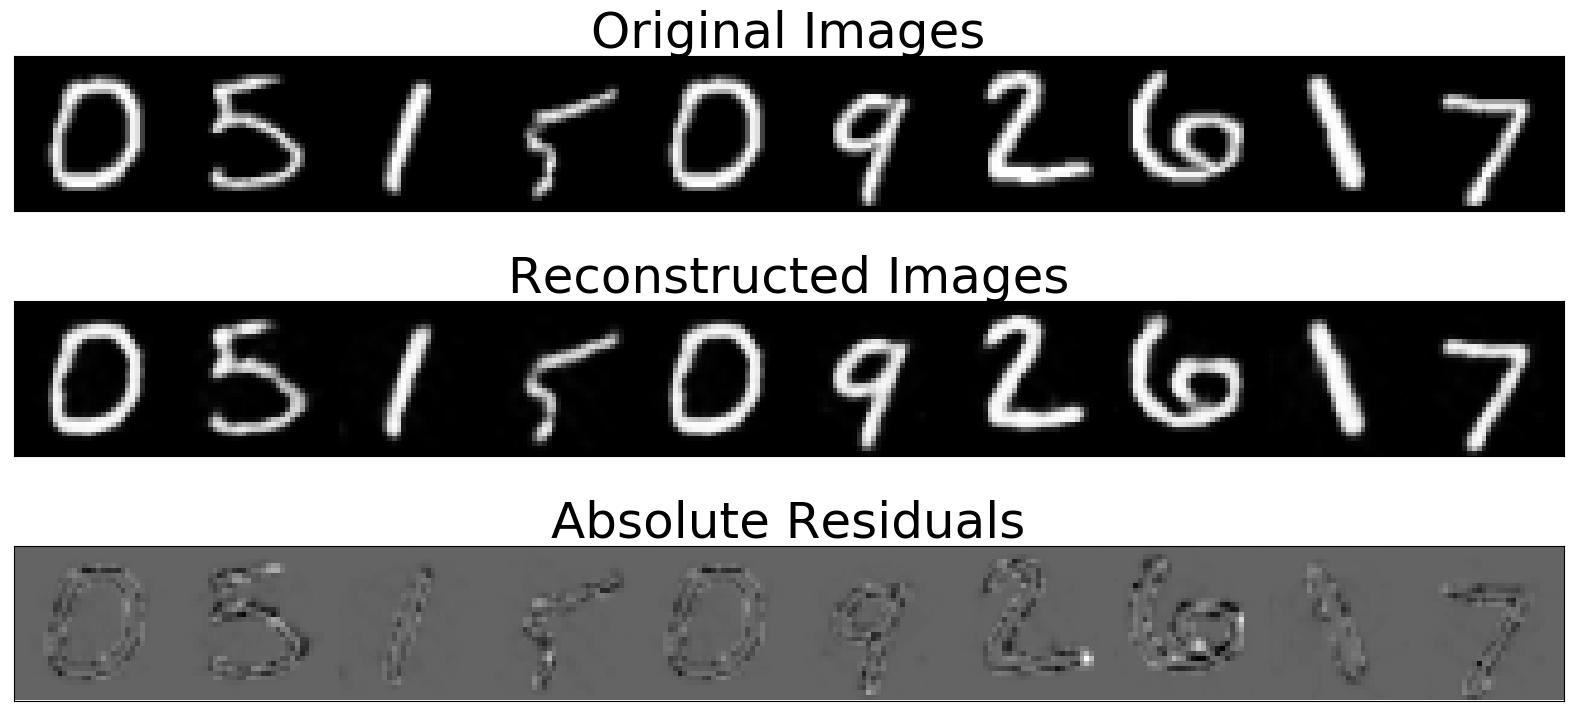

In [63]:
x_hat_ = Array{Float32}(reshape(x_hat, 32,32,1,64))
x_ = Array{Float32}(reshape(x, 32,32,1,64))
display(plot_reconstructed_images_pyplot(x_, x_hat_; transpose_image = false))
figname = "mnist_gon_detach_test_reconstructions_nz256"
plt.savefig(joinpath("Evaluation_Notebook", figname))